In [86]:
# imports
import numpy as np
from projector import Projector
from facenet_pytorch import MTCNN
import pdb
import torch
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# instantiate projector
projector = Projector(learning_rate=1e-3)

<Figure size 432x288 with 0 Axes>

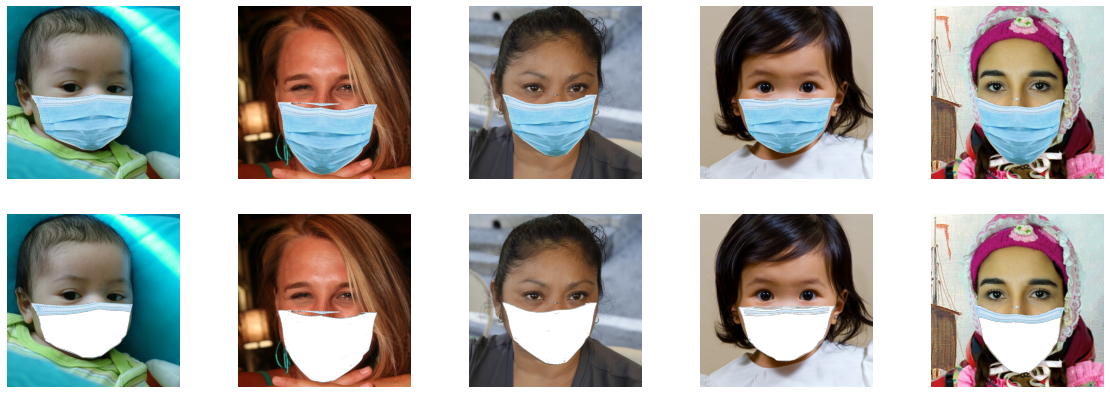

In [88]:
# load training data
num_faces = 100
img_size = 128
masked_faces = torch.zeros((num_faces, 3, img_size, img_size))
transparent_faces = torch.zeros((num_faces, 1, img_size, img_size))
plt.figure()
fig, axes = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(7)
mtcnn = MTCNN(image_size=img_size)
face_id = 0
skipped = 0
while face_id < num_faces:
    # get image paths
    face_id_text = str(100000 + face_id + skipped)[1:]
    masked_path = '../data/masked/{}_Mask.jpg'.format(face_id_text)
    transparent_path = '../data/transparent/{}_Mask.png'.format(face_id_text)
    
    # load images
    try:
        masked_img = Image.open(masked_path)
        transparent_img = Image.open(transparent_path)
    except:  # skip missing images
        skipped += 1
        continue
        
    # process images
    masked_tensor = mtcnn(masked_img)
    transparent_tensor = Resize((img_size,img_size))(ToTensor()(transparent_img))[3,:,:]
    if masked_tensor is None or transparent_tensor is None:
        skipped += 1
        continue
        
    # display images
    if face_id < 5:
        axes[0,face_id].imshow(masked_img)
        axes[0,face_id].set_axis_off()
        axes[1,face_id].imshow(transparent_img)
        axes[1,face_id].set_axis_off()
    
    # process and save images into respective tensors
    masked_faces[face_id] = masked_tensor
    transparent_faces[face_id] = transparent_tensor
    face_id += 1

In [89]:
# split data into training and testing sets
train_input, train_output = masked_faces[:80,:,:,:], transparent_faces[:80,:,:]
test_input, test_output = masked_faces[80:,:,:,:], transparent_faces[80:,:,:]

# fit projector to training data and evaluate loss on test data
train_loss = projector.fit(train_input, train_output, num_epochs=100)
test_loss = projector.evaluate(test_input, test_output)
print('final training loss: {}'.format(train_loss))
print('final test loss: {}'.format(test_loss))
print('bias: {}'.format(train_loss))
print('variance: {}'.format(test_loss - train_loss))

Epoch 10 loss: 0.009514631237834692
Epoch 20 loss: 0.0089456794783473
Epoch 30 loss: 0.008661337802186609
Epoch 40 loss: 0.00839366945438087
Epoch 50 loss: 0.008220348414033652
Epoch 60 loss: 0.008016816992312669
Epoch 70 loss: 0.007949741557240486
Epoch 80 loss: 0.007694326294586063
Epoch 90 loss: 0.007575072487816215
Epoch 100 loss: 0.007398654194548726
final training loss: 0.007398654194548726
final test loss: 0.003136662393808365
bias: 0.007398654194548726
variance: -0.004261991800740361


<Figure size 432x288 with 0 Axes>

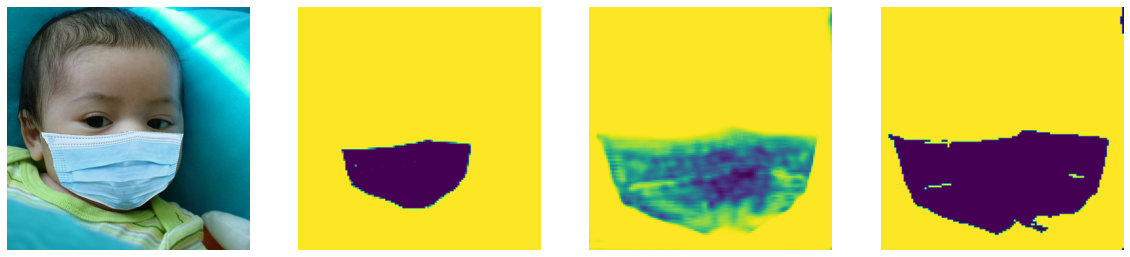

In [102]:
# display outputs
plt.figure()
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.set_figheight(7)

# display original image
img_id = 0
img_id_text = str(100000 + img_id)[1:]
original_img = Image.open('../data/masked/{}_Mask.jpg'.format(img_id_text))
axes[0].imshow(original_img)
axes[0].set_axis_off()

# display desired transparency mask
desired_mask = torch.transpose(transparent_faces[img_id,:,:], 0, 2)
desired_mask = torch.transpose(desired_mask, 0, 1)
axes[1].imshow(desired_mask)
axes[1].set_axis_off()

# display output transparency mask
output_mask = projector.predict(torch.unsqueeze(masked_faces[img_id,:,:,:], 0))[0]
output_mask = torch.transpose(output_mask, 0, 2)
output_mask = torch.transpose(output_mask, 0, 1)
output_mask = output_mask.detach().numpy()
# pdb.set_trace()
axes[2].imshow(output_mask)
axes[2].set_axis_off()

# display processed transparency mask
avg = np.mean(output_mask)
avg_mask = (output_mask > avg).astype('int')
axes[3].imshow(avg_mask)
axes[3].set_axis_off()